<a href="https://colab.research.google.com/github/SantiB17/AE-Experimentation/blob/main/Autoencoder_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image

In [4]:
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
transform = transforms.Compose([
      transforms.ToTensor(),
])

In [5]:
trainset = datasets.FashionMNIST(
    root='./data', 
    train=True,
    download=True,
    transform=transform
)
testset = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

trainloader = DataLoader(
    trainset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
testloader = DataLoader(
    testset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [6]:
def get_device():
  if torch.cuda.is_available():
    device = 'cuda:0'
  else:
    device = 'cpu'
  return device

def make_dir():
  image_dir = 'FashionMNIST_Images'
  if not os.path.exists(image_dir):
    os.makedirs(image_dir)

def save_decoded_image(img, epoch):
  img = img.view(img.size(0), 1, 28, 28)
  save_image = (img, './FashionMNIST_Images/linear_ae_image{}.png'.format(epoch))

**Autoencoder Network**

In [7]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=256)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=128, out_features=64)
        self.enc4 = nn.Linear(in_features=64, out_features=32)
        self.enc5 = nn.Linear(in_features=32, out_features=16)
        # decoder 
        self.dec1 = nn.Linear(in_features=16, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=256)
        self.dec5 = nn.Linear(in_features=256, out_features=784)
        
    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = F.relu(self.enc5(x))
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x))
        return x
net = Autoencoder()
print(net)

Autoencoder(
  (enc1): Linear(in_features=784, out_features=256, bias=True)
  (enc2): Linear(in_features=256, out_features=128, bias=True)
  (enc3): Linear(in_features=128, out_features=64, bias=True)
  (enc4): Linear(in_features=64, out_features=32, bias=True)
  (enc5): Linear(in_features=32, out_features=16, bias=True)
  (dec1): Linear(in_features=16, out_features=32, bias=True)
  (dec2): Linear(in_features=32, out_features=64, bias=True)
  (dec3): Linear(in_features=64, out_features=128, bias=True)
  (dec4): Linear(in_features=128, out_features=256, bias=True)
  (dec5): Linear(in_features=256, out_features=784, bias=True)
)


In [8]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

**Train and Test Functions**

In [9]:
def train(net, trainloader, NUM_EPOCHS):
  train_loss = []
  for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    for data in trainloader:
      img, _ = data
      img = img.to(device)
      img = img.view(img.size(0), -1)
      optimizer.zero_grad()
      outputs = net(img)
      loss = criterion(outputs, img)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

    loss = running_loss / len(trainloader)
    train_loss.append(loss)
    print('Epoch {} of {}, Train Loss: {:.3f}'.format(
        epoch+1, NUM_EPOCHS, loss))
    if epoch % 5 == 0:
      save_decoded_image(outputs.cpu().data, epoch)
      
  return train_loss

def test_image_reconstruction(net, testloader):
  for batch in testloader:
    img, _ = batch
    img = img.to(device)
    img = img.view(img.size(0), -1)
    outputs = net(img)
    outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
    save_image(outputs, 'fashionmnist_reconstruction.png')
    break



**Training the Autoencoder Network**

cuda:0
Epoch 1 of 50, Train Loss: 0.077
Epoch 2 of 50, Train Loss: 0.040
Epoch 3 of 50, Train Loss: 0.033
Epoch 4 of 50, Train Loss: 0.029
Epoch 5 of 50, Train Loss: 0.027
Epoch 6 of 50, Train Loss: 0.026
Epoch 7 of 50, Train Loss: 0.025
Epoch 8 of 50, Train Loss: 0.024
Epoch 9 of 50, Train Loss: 0.024
Epoch 10 of 50, Train Loss: 0.023
Epoch 11 of 50, Train Loss: 0.023
Epoch 12 of 50, Train Loss: 0.023
Epoch 13 of 50, Train Loss: 0.023
Epoch 14 of 50, Train Loss: 0.022
Epoch 15 of 50, Train Loss: 0.022
Epoch 16 of 50, Train Loss: 0.022
Epoch 17 of 50, Train Loss: 0.021
Epoch 18 of 50, Train Loss: 0.021
Epoch 19 of 50, Train Loss: 0.021
Epoch 20 of 50, Train Loss: 0.021
Epoch 21 of 50, Train Loss: 0.020
Epoch 22 of 50, Train Loss: 0.020
Epoch 23 of 50, Train Loss: 0.020
Epoch 24 of 50, Train Loss: 0.019
Epoch 25 of 50, Train Loss: 0.019
Epoch 26 of 50, Train Loss: 0.019
Epoch 27 of 50, Train Loss: 0.019
Epoch 28 of 50, Train Loss: 0.019
Epoch 29 of 50, Train Loss: 0.018
Epoch 30 of 50, 

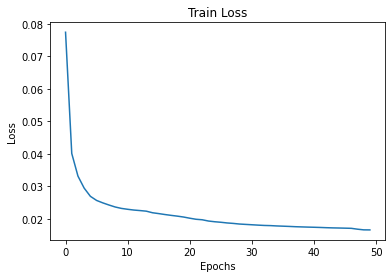

In [10]:
device = get_device()
print(device)
net.to(device)

make_dir()

train_loss = train(net, trainloader, NUM_EPOCHS)
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('AE_FashionMNIST_Loss.png')

test_image_reconstruction(net, testloader)